In [1]:
from torch import nn
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
%%capture
# For this example, we will use a pretrained ResNet50.
model = torchvision.models.resnet50(pretrained=True)
model = model.eval()
model = model.to(device)

In [3]:
%%capture
# This class saves each specified layer's activation maps.
class FeatureBuffer(nn.Module):

    def __init__(self, model, layers=['layer2','layer3']):
        self.features = []
        self.hooks = []
        for layer in layers:
            feature = model._modules.get(layer)
            self.hooks.append(feature.register_forward_hook(self.hook_fn))
    
    def hook_fn(self, module, _input, _output): 
        self.features.append(_output)

    def clean(self):
        self.features = []

# Register hook.
fb = FeatureBuffer(model)

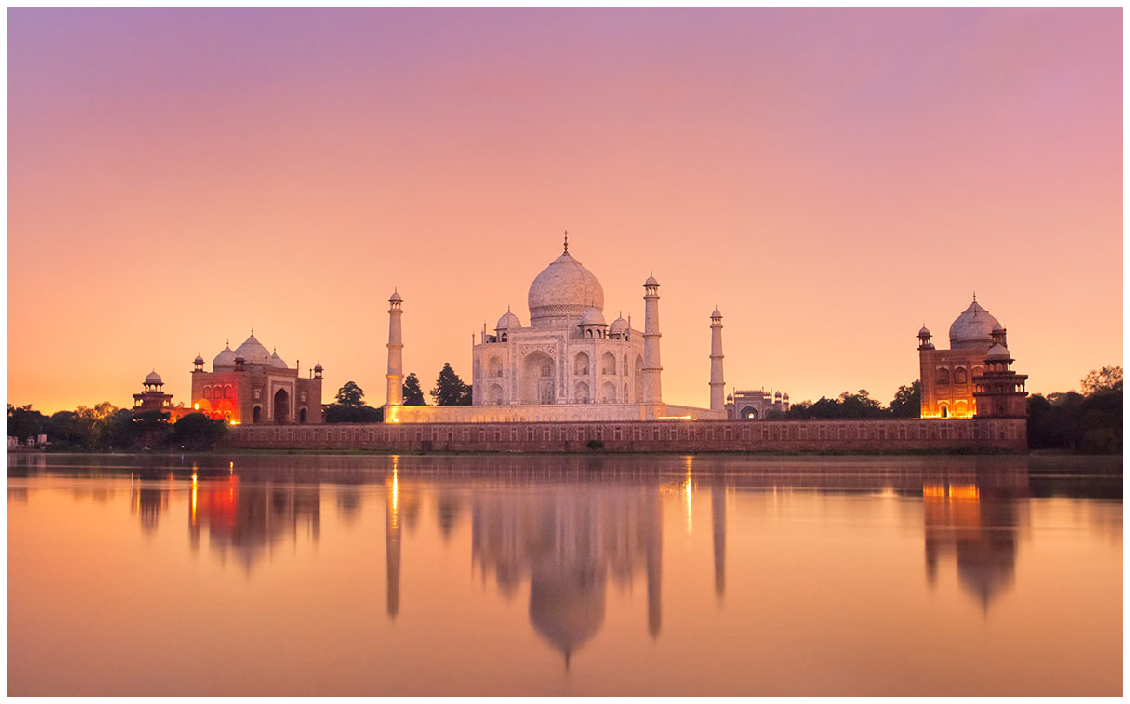

In [12]:
# ImageNet standard normalization.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
tnfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
# Load and pre-process image
img = Image.open('india.jpg').convert('RGB')
input_tensor = tnfs(img).to(device)
input_tensor = input_tensor.unsqueeze(0).requires_grad_(True)
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

In [10]:
# For the loss, we compute the average of each activation map of each layer, and sum them up.
def compute_loss(feature_maps):
    loss = torch.stack([torch.mean(feature_map) for feature_map in feature_maps])
    return torch.sum(loss)

# Number of iterations.
NUM_EPOCHS = 200

# Modifying factor of image.
LEARNING_RATE = 0.01

pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    
    # Gradient is none at first iteration.
    if input_tensor.grad is not None:
        # Zero grads for image.
        input_tensor.grad.zero_()
    
    # Forward pass.
    _ = torch.argmax(model(input_tensor))

    # Compute loss.
    loss = compute_loss(fb.features)
    
    # Clean activation maps for next iteration.
    fb.clean()
    pbar.set_description(f"Loss: {loss}")

    # Compute gradient.
    loss.backward()

    # Standarize gradient (acording to blogpost).
    gradient = input_tensor.grad.data/(torch.std(input_tensor.grad.data)+1e-8)
    
    # Update image based on gradients.
    input_tensor.data += LEARNING_RATE * gradient

    # Clip resulting image values.
    for c in range(3):
        m, s = mean[c], std[c]
        input_tensor.data[0, c] = torch.clamp(input_tensor.data[0, c], -m / s, (1 - m) / s)

Loss: 0.3826800286769867: 100%|██████████| 200/200 [00:10<00:00, 19.99it/s] 


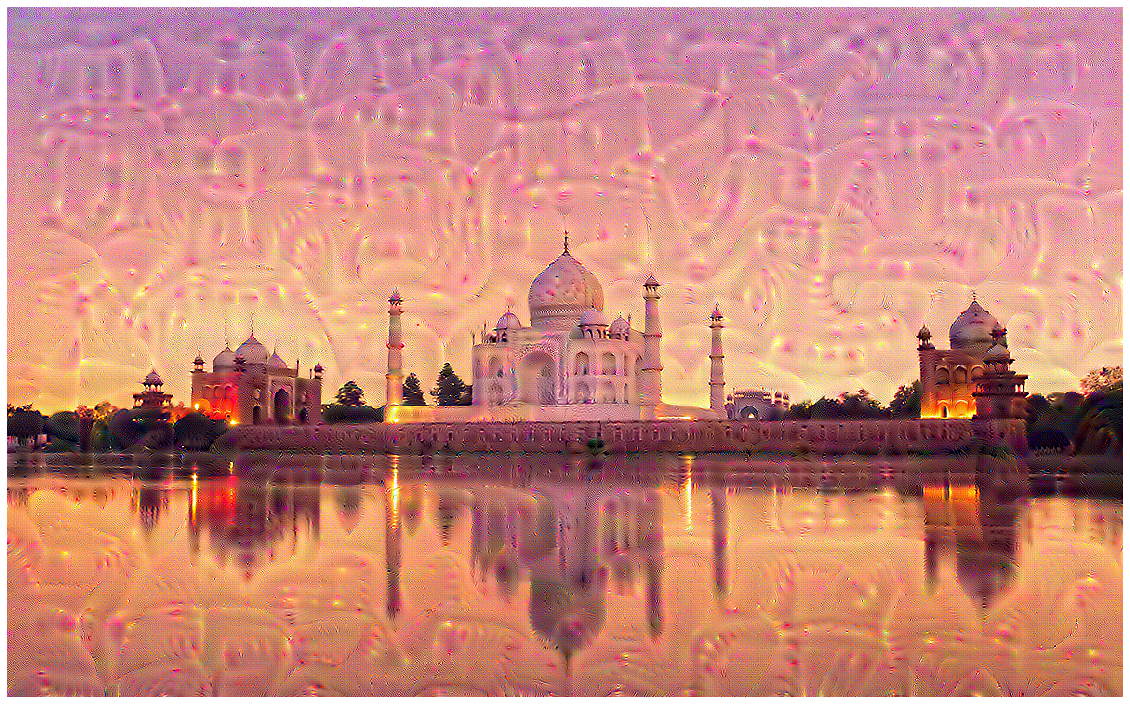

In [11]:
# Image must be unnormalized same std and mean.
inv_tnfs = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
])
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(transforms.ToPILImage()(inv_tnfs(input_tensor[0].cpu())))
plt.show()